In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,KFold
import optuna
from optuna.samplers import TPESampler

In [2]:
os.chdir("../input/tabular-playground-series-jan-2021")

# 1. Data loading

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

There is no missing data in both train data and test data.

# 2. Data visualization

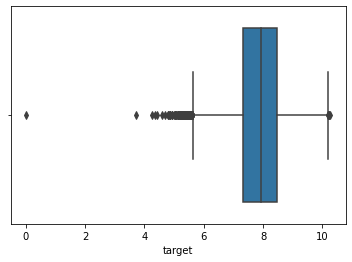

In [4]:
sns.boxplot(train.target)

There is an possible outlier with a value of 0.

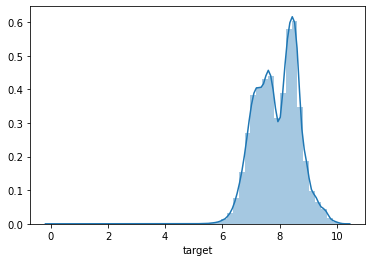

In [5]:
sns.distplot(train.target)

This is an bimodal distribution

# **3. Data Processing**

Feature engineering

In [5]:
X=train[train.columns.drop(["id","target"])]
y=train["target"]

In [6]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2,include_bias=False) #interaction_only=Trueにしたらやや悪化した
X_poly=poly.fit_transform(X)
X_poly=pd.DataFrame(X_poly)
X_poly

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,...,0.849774,0.799018,0.810044,0.281538,0.751294,0.761661,0.264722,0.772171,0.268375,0.093276
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,...,0.193488,0.191331,0.162734,0.162526,0.189199,0.160921,0.160715,0.136869,0.136693,0.136519
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,...,0.321497,0.384265,0.500632,0.171830,0.459288,0.598374,0.205377,0.779580,0.267572,0.091838
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,...,0.592275,0.629638,0.703626,0.215123,0.669357,0.748013,0.228693,0.835911,0.255567,0.078136
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,...,0.967420,0.885674,0.920545,0.428615,0.810835,0.842760,0.392397,0.875942,0.407847,0.189898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,...,0.099475,0.078118,0.153454,0.091071,0.061346,0.120508,0.071518,0.236724,0.140489,0.083377
299996,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,...,0.129781,0.129962,0.105386,0.223350,0.130144,0.105534,0.223663,0.085577,0.181367,0.384381
299997,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,...,0.241803,0.254044,0.085326,0.351370,0.266905,0.089646,0.369158,0.030110,0.123990,0.510585
299998,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,...,0.969530,0.985740,0.062974,0.371894,1.002221,0.064027,0.378112,0.004090,0.024156,0.142652


In [7]:
!pip install BorutaShap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
X_poly.columns=X_poly.columns.astype("str")

In [17]:
from BorutaShap import BorutaShap
model=lgbm.LGBMRegressor()
Feature_Selector=BorutaShap(model=model, importance_measure="shap", classification=False)
Feature_Selector.fit(X=X_poly, y=y,n_trials=35, random_state=0)

"""
56 attributes confirmed important: ['49', '107', '27', '1', '83', '110', '28', '86', '2', '14', '80', '11', '87', '6', '61', '3', '0', '16', '114', '37', '89', '98', '70', '10', '5', '62', '4', '12', '81', '104', '51', '39', '23', '111', '13', '9', '26', '102', '33', '75', '88', '94', '8', '99', '79', '108', '44', '50', '71', '24', '7', '17', '59', '112', '22', '57']
36 attributes confirmed unimportant: ['84', '43', '82', '54', '40', '115', '53', '45', '52', '103', '73', '56', '100', '41', '35', '90', '72', '109', '68', '64', '55', '116', '74', '78', '97', '20', '113', '91', '34', '36', '92', '118', '19', '93', '65', '77']
27 tentative attributes remains: ['95', '101', '76', '47', '21', '31', '38', '25', '60', '30', '32', '63', '105', '67', '117', '66', '96', '58', '15', '69', '106', '18', '46', '48', '85', '42', '29']
"""

100%|██████████| 35/35 [2:45:28<00:00, 283.68s/it]  

56 attributes confirmed important: ['49', '107', '27', '1', '83', '110', '28', '86', '2', '14', '80', '11', '87', '6', '61', '3', '0', '16', '114', '37', '89', '98', '70', '10', '5', '62', '4', '12', '81', '104', '51', '39', '23', '111', '13', '9', '26', '102', '33', '75', '88', '94', '8', '99', '79', '108', '44', '50', '71', '24', '7', '17', '59', '112', '22', '57']
36 attributes confirmed unimportant: ['84', '43', '82', '54', '40', '115', '53', '45', '52', '103', '73', '56', '100', '41', '35', '90', '72', '109', '68', '64', '55', '116', '74', '78', '97', '20', '113', '91', '34', '36', '92', '118', '19', '93', '65', '77']
27 tentative attributes remains: ['95', '101', '76', '47', '21', '31', '38', '25', '60', '30', '32', '63', '105', '67', '117', '66', '96', '58', '15', '69', '106', '18', '46', '48', '85', '42', '29']


In [18]:
selected_features = Feature_Selector.Subset()
selected_columns=list(selected_features.columns)
print(selected_columns)
"""['49', '107', '27', '1', '83', '110', '28', '86', '2', '14', '80', '11', '87', '6', '61', '3', '0', '16', '114', '37', '89', '98', '70', '10', '5', '62', '4', '12', '81', '104', '51', '39', '23', '111', '13', '9', '26', '102', '33', '75', '88', '94', '8', '99', '79', '108', '44', '50', '71', '24', '7', '17', '59', '112', '22', '57']"""

['49', '107', '27', '1', '83', '110', '28', '86', '2', '14', '80', '11', '87', '6', '61', '3', '0', '16', '114', '37', '89', '98', '70', '10', '5', '62', '4', '12', '81', '104', '51', '39', '23', '111', '13', '9', '26', '102', '33', '75', '88', '94', '8', '99', '79', '108', '44', '50', '71', '24', '7', '17', '59', '112', '22', '57']


In [ ]:
Feature_Selector.plot(which_features='accepted', figsize=(20,12))

In [8]:
selected_columns=['49', '107', '27', '1', '83', '110', '28', '86', '2', '14', '80', '11', '87', '6', '61', '3', '0', '16', '114', '37', '89', '98', '70', '10', '5', '62', '4', '12', '81', '104', '51', '39', '23', '111', '13', '9', '26', '102', '33', '75', '88', '94', '8', '99', '79', '108', '44', '50', '71', '24', '7', '17', '59', '112', '22', '57']
X_poly=X_poly[selected_columns]
X_poly.head()

,49,107,27,1,83,110,28,86,2,14,...,44,50,71,24,7,17,59,112,22,57
0,0.593631,0.684900,0.204745,0.811300,0.793347,0.799018,0.658207,0.694228,0.643968,0.449423,...,0.551207,0.558174,0.246265,0.617987,0.285542,0.195614,0.227428,0.281538,0.374242,0.083319
1,0.301797,0.160055,0.143379,0.621104,0.260941,0.191331,0.385770,0.220999,0.686102,0.150585,...,0.308612,0.298434,0.280029,0.170694,0.580748,0.194472,0.216813,0.162526,0.162336,0.291041
2,0.171000,0.726933,0.253029,0.227436,0.256181,0.384265,0.051727,0.416714,0.301584,0.697142,...,0.250066,0.204386,0.411260,0.473422,0.558771,0.244981,0.241567,0.171830,0.490620,0.163948
3,0.420881,0.531054,0.229411,0.160155,0.566645,0.629638,0.025650,0.437234,0.546887,0.673562,...,0.429365,0.447432,0.231079,0.631612,0.823267,0.595920,0.421752,0.215123,0.471469,0.597778
4,0.298811,0.808096,0.407568,0.421235,0.237279,0.885674,0.177439,0.420586,0.303801,0.874745,...,0.252194,0.273562,0.599358,0.919916,0.604157,0.823245,0.760000,0.428615,0.818049,0.531788


In [9]:
test1=test[test.columns.drop("id")]
poly=PolynomialFeatures(degree=2,include_bias=False)
test_poly=poly.fit_transform(test1)
test_poly=pd.DataFrame(test_poly)
test_poly.columns=test_poly.columns.astype("str")
test_poly=test_poly[selected_columns]
test_poly

,49,107,27,1,83,110,28,86,2,14,...,44,50,71,24,7,17,59,112,22,57
0,0.330841,0.124994,0.128893,0.738780,0.385273,0.384901,0.545796,0.270457,0.600939,0.125033,...,0.275234,0.420137,0.199736,0.194671,0.422249,0.103738,0.127832,0.200680,0.130550,0.123878
1,0.096229,0.732269,0.465407,0.189756,0.152374,0.200484,0.036007,0.311726,0.215531,0.823052,...,0.114007,0.096781,0.135310,0.405052,0.521112,0.789206,0.694697,0.229043,0.721041,0.453323
2,0.132228,0.074954,0.148439,0.355353,0.149605,0.047183,0.126276,0.088614,0.623972,0.032144,...,0.200186,0.138928,0.062894,0.037993,0.776422,0.078494,0.100304,0.175451,0.039850,0.339927
3,0.245511,0.103370,0.214972,0.181049,0.256722,0.230869,0.032779,0.175151,0.551368,0.129157,...,0.265801,0.285876,0.145571,0.160025,0.362793,0.074172,0.071345,0.266349,0.136472,0.074875
4,0.553173,0.400733,0.083704,0.682607,0.560461,0.658998,0.465952,0.379469,0.676481,0.112755,...,0.393523,0.545173,0.227957,0.274583,0.350158,0.073694,0.111242,0.203838,0.150741,0.076847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.119628,0.105429,0.096418,0.677578,0.083601,0.047579,0.459112,0.081668,0.550852,0.125214,...,0.140497,0.120685,0.209806,0.076846,0.635979,0.307717,0.245626,0.059174,0.096036,0.553055
199996,0.098369,0.146334,0.096249,0.135627,0.301995,0.230246,0.018395,0.252618,0.218393,0.059151,...,0.094678,0.111637,0.279940,0.109547,0.650107,0.192816,0.364440,0.178254,0.110365,0.515403
199997,0.204122,0.169798,0.187308,0.683893,0.307420,0.152289,0.467709,0.246949,0.533434,0.257022,...,0.191292,0.212295,0.125117,0.193996,0.267105,0.097824,0.085941,0.141378,0.200813,0.051540
199998,0.105787,0.085080,0.135149,0.553112,0.076156,0.060921,0.305933,0.069718,0.495284,0.121014,...,0.147831,0.141267,0.233003,0.074301,0.265841,0.299690,0.217645,0.082980,0.116276,0.229022


# 4. Modeling

In [10]:
train_x, val_x, train_y, val_y=train_test_split(X_poly,y,random_state=42, test_size=0.2,shuffle=True)

In [11]:
#LGBMRegressor + optuna
sampler=TPESampler(seed=42)

def create_model_lgbm(trial):
    num_leaves=trial.suggest_int("num_leaves",2,31)
    n_estimators=trial.suggest_int("n_estimators",50,300)
    max_depth=trial.suggest_int("max_depth",3,8)
    min_child_samples=trial.suggest_int("min_child_samples",100,1200)
    learning_rate=trial.suggest_uniform("learning_rate",0.0001,0.99)
    min_data_in_leaf=trial.suggest_int('min_data_in_leaf',5,90)
    feature_fraction=trial.suggest_uniform('feature_fraction',0.0001,1.0)
    
    model=lgbm.LGBMRegressor(
    num_leaves=num_leaves,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    min_data_in_leaf=min_data_in_leaf,
    learning_rate=learning_rate,
    feature_fraction=feature_fraction,
    random_state=42)
    
    return model


#目的関数
def objective_lgbm(trial):
    model=create_model_lgbm(trial)
    model.fit(train_x,train_y)
    preds=model.predict(val_x)
    score=mean_squared_error(val_y,preds, squared=False)
    return score


study=optuna.create_study(direction="minimize", sampler=sampler)
optuna.logging.disable_default_handler()#don't show log
study.optimize(objective_lgbm, n_trials=100)


#最適解
print(study.best_params)
print(study.best_value)
#print(study.best_trial)

[I 2021-01-04 01:10:48,430] A new study created in memory with name: no-name-35e448d1-818a-4eac-ae08-0b092ee5a510


{'num_leaves': 31, 'n_estimators': 248, 'max_depth': 6, 'min_child_samples': 624, 'learning_rate': 0.1398176065850747, 'min_data_in_leaf': 45, 'feature_fraction': 0.3716978452220932}
0.6977029644331942


In [12]:
params=study.best_params
#{'num_leaves': 31, 'n_estimators': 248, 'max_depth': 6, 'min_child_samples': 624, 'learning_rate': 0.1398176065850747, 'min_data_in_leaf': 45, 'feature_fraction': 0.3716978452220932}
#{'num_leaves': 26, 'n_estimators': 273, 'max_depth': 6, 'min_child_samples': 738, 'learning_rate': 0.1270857106337994, 'min_data_in_leaf': 87, 'feature_fraction': 0.33888927402101837}

lightGBM regressor + StratifiedKFold

In [14]:
tmp=X_poly.copy()
import random
fold_list = [1,2,3,4,5]
folds = []
for i in range(int((tmp.shape[0])/5)):
    random.shuffle(fold_list)
    folds.extend(fold_list)
tmp['fold'] = folds
tmp.head(7)

,49,107,27,1,83,110,28,86,2,14,...,50,71,24,7,17,59,112,22,57,fold
0,0.593631,0.684900,0.204745,0.811300,0.793347,0.799018,0.658207,0.694228,0.643968,0.449423,...,0.558174,0.246265,0.617987,0.285542,0.195614,0.227428,0.281538,0.374242,0.083319,4
1,0.301797,0.160055,0.143379,0.621104,0.260941,0.191331,0.385770,0.220999,0.686102,0.150585,...,0.298434,0.280029,0.170694,0.580748,0.194472,0.216813,0.162526,0.162336,0.291041,2
2,0.171000,0.726933,0.253029,0.227436,0.256181,0.384265,0.051727,0.416714,0.301584,0.697142,...,0.204386,0.411260,0.473422,0.558771,0.244981,0.241567,0.171830,0.490620,0.163948,1
3,0.420881,0.531054,0.229411,0.160155,0.566645,0.629638,0.025650,0.437234,0.546887,0.673562,...,0.447432,0.231079,0.631612,0.823267,0.595920,0.421752,0.215123,0.471469,0.597778,3
4,0.298811,0.808096,0.407568,0.421235,0.237279,0.885674,0.177439,0.420586,0.303801,0.874745,...,0.273562,0.599358,0.919916,0.604157,0.823245,0.760000,0.428615,0.818049,0.531788,5
5,0.091258,0.079985,0.103364,0.258867,0.043992,0.070082,0.067012,0.049468,0.327373,0.124343,...,0.082303,0.071454,0.098297,0.273710,0.283024,0.189300,0.081713,0.108614,0.219687,2
6,0.127329,0.145183,0.063297,0.803934,0.187334,0.071671,0.646310,0.137006,0.580900,0.067131,...,0.189941,0.321976,0.056792,0.562059,0.083658,0.102207,0.053549,0.075388,0.181480,5


In [ ]:
predictions = np.zeros(len(test_poly))
for fold in range(1,6):
    train_index_list = tmp[tmp['fold'] != fold].index
    test_index_list = tmp[tmp['fold'] == fold].index
                          
    X_train = X_poly.iloc[train_index_list]
    y_train = y.iloc[train_index_list]
    X_val = X_poly.iloc[test_index_list]
    y_val = y.iloc[test_index_list]

    model=lgbm.LGBMRegressor(**params)
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train,eval_metric='rmse', eval_set=eval_set, verbose=False)#,early_stopping_rounds=5,
    predictions += model.predict(test_poly)
predictions = predictions/5

In [ ]:
test["target"]=predictions

# 5. Submission

In [ ]:
sample_submission=pd.read_csv("sample_submission.csv")
sample_submission.head()

In [ ]:
sample_submission=pd.merge(sample_submission["id"],test[["id","target"]], on="id")
sample_submission.head()

In [ ]:
sample_submission.to_csv("/kaggle/working/submission5.csv", index=False)